In [1]:
import pandas as pd
import numpy as np
import spacy
from spacy import displacy
import networkx as nx

import matplotlib.pyplot as plt

In [2]:
NER = spacy.load('it_core_news_sm')

In [4]:
script= 'data/FiloAct2.txt'
script_text = open(script, encoding='utf-8').read()
script_doc = NER(script_text)

In [5]:
# quick test - identified entities
displacy.render(script_doc[0:2000], style="ent", jupyter=True)

In [6]:
# Read characters
character_df = pd.read_csv("data/characters.csv")
#character_df

In [7]:
import re 
character_df['character'] = character_df['character'].apply(lambda x: re.sub("[\(].*?[\)]", "", x)) 
character_df['character_firstname'] = character_df['character'].apply(lambda x: x.split(' ', 1)[0])

In [8]:
sent_entity_df = []

# Loop through sentences, store named entity list for each sentence
for sent in script_doc.sents:
    entity_list = [ent.text for ent in sent.ents]
    sent_entity_df.append({"sentence": sent, "entities": entity_list})
    
sent_entity_df = pd.DataFrame(sent_entity_df)

In [9]:
sent_entity_df


,sentence,entities
0,"(﻿, \n\n\n, ATTO, SECONDO, \n, L’, indomani, .)",[ATTO]
1,"(La, medesima, scena, del, primo, atto, .)",[]
2,"(Per, pulire, il, pavimento, la, serva, ha, sp...",[]
3,"(qualcuna, portandola, sul, terrazzo, ,, altre...",[Domenico]
4,"(Il, tappeto, ,, sul, quale, fa, centro, il, t...",[]
...,...,...
720,"((, Prende, dal, seno, un, medaglione, ,, lo, ...",[]
721,"(Ne, strappa, un, pezzetto, ,, poi, a, Domenic...",[Domenico]
722,"(Tieni, .)",[Tieni]
723,"((, Poggia, il, biglietto, sul, tavolo, e, ,, ...",[Poggia]


In [10]:
# Function to filter out non-character entities
def filter_entity(ent_list, character_df):
    return [ent for ent in ent_list 
            if ent in list(character_df.character) 
            or ent in list(character_df.character_firstname)]

In [11]:
filter_entity(["Filomena", "Thu", "2"], character_df)

['Filomena']

In [12]:
sent_entity_df['character_entities'] = sent_entity_df['entities'].apply(lambda x: filter_entity(x, character_df))

# Filter out sentences that don't have any character entities
sent_entity_df_filtered = sent_entity_df[sent_entity_df['character_entities'].map(len) > 0]
sent_entity_df_filtered.head(10)

,sentence,entities,character_entities
3,"(qualcuna, portandola, sul, terrazzo, ,, altre...",[Domenico],[Domenico]
6,"(Lucia, è, la, serva, di, casa, :)",[Lucia],[Lucia]
11,"(SCENA, PRIMA, \n, (, LUCIA, e, ALFREDO, ,, po...","[PRIMA, LUCIA, ALFREDO, ROSALIA, ALFREDO, Stan...",[Lucia]
15,"(..., Io, sono, stanco, morto, !, (, Siede, pr...","[Siede, Domenico, Caracciolo]",[Domenico]
21,"(Non, posso, più, fare, le, nottate, insieme, ...",[Lucia],[Lucia]
22,"(LUCIA, (, Che, ha, rimesso, a, posto, le, sed...","[LUCIA, Alfredo]",[Alfredo]
26,"(una, tazza, me, la, sono, presa, io, ,, un’, ...","[Rosalia, Filomena, don Domenico, ALFREDO, Fis...","[Rosalia, Filomena]"
29,"(donna, Rosalia, il, caffè, non, l’, ha, fatto...",[Rosalia],[Rosalia]
33,"(E, perché, non, l’, ha, fatto, Rosalia, ?)",[Rosalia],[Rosalia]
35,"(Dice, che, doveva, portare, tre, lettere, urg...",[Filomena],[Filomena]


In [13]:
# Take only first name of characters
sent_entity_df_filtered['character_entities'] = sent_entity_df_filtered['character_entities'].apply(lambda x: [item.split()[0]
                                                                                                               for item in x])


C:\Users\Eleonora\AppData\Local\Temp\ipykernel_5460\1239962011.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sent_entity_df_filtered['character_entities'] = sent_entity_df_filtered['character_entities'].apply(lambda x: [item.split()[0]


In [14]:
pd.reset_option('^display.', silent=True)
sent_entity_df_filtered

,sentence,entities,character_entities
3,"(qualcuna, portandola, sul, terrazzo, ,, altre...",[Domenico],[Domenico]
6,"(Lucia, è, la, serva, di, casa, :)",[Lucia],[Lucia]
11,"(SCENA, PRIMA, \n, (, LUCIA, e, ALFREDO, ,, po...","[PRIMA, LUCIA, ALFREDO, ROSALIA, ALFREDO, Stan...",[Lucia]
15,"(..., Io, sono, stanco, morto, !, (, Siede, pr...","[Siede, Domenico, Caracciolo]",[Domenico]
21,"(Non, posso, più, fare, le, nottate, insieme, ...",[Lucia],[Lucia]
...,...,...,...
708,"(..., (, Verso, lo, «, studio, », energica, ),...","[Avvocato, Alludendo, Diana, Hai]","[Avvocato, Diana]"
710,"((, Chiamando, verso, sinistra, ), Rosalia, ,,...",[Rosalia],[Rosalia]
714,"((, Dallo, «, studio, », compare, Nocella, ,, ...","[Nocella, Diana, Alfredo]","[Diana, Alfredo]"
717,"((, Dal, fondo, viene, anche, Lucia, ), Hai, c...","[Lucia, Domenico]","[Lucia, Domenico]"


In [15]:
window_size = 5
relationships = []

for i in range(sent_entity_df_filtered.index[-1]):
    end_i = min(i+5, sent_entity_df_filtered.index[-1])
    char_list = sum((sent_entity_df_filtered.loc[i: end_i].character_entities), [])
    
    # Remove duplicated characters that are next to each other
    char_unique = [char_list[i] for i in range(len(char_list)) 
                   if (i==0) or char_list[i] != char_list[i-1]]
    
    if len(char_unique) > 1:
        for idx, a in enumerate(char_unique[:-1]):
            b = char_unique[idx + 1]
            relationships.append({"source": a, "target": b})

In [16]:
relationship_df = pd.DataFrame(relationships)

In [17]:
pd.set_option('display.max_rows', None)
relationship_df

,source,target
0,Domenico,Lucia
1,Domenico,Lucia
2,Domenico,Lucia
3,Lucia,Domenico
4,Lucia,Domenico
5,Lucia,Alfredo
6,Lucia,Alfredo
7,Lucia,Alfredo
8,Lucia,Alfredo
9,Lucia,Alfredo


In [18]:
# Sort the cases with a->b and b->a
relationship_df = pd.DataFrame(np.sort(relationship_df.values, axis = 1), columns = relationship_df.columns)
relationship_df

,source,target
0,Domenico,Lucia
1,Domenico,Lucia
2,Domenico,Lucia
3,Domenico,Lucia
4,Domenico,Lucia
5,Alfredo,Lucia
6,Alfredo,Lucia
7,Alfredo,Lucia
8,Alfredo,Lucia
9,Alfredo,Lucia


In [19]:
relationship_df["value"] = 1
relationship_df = relationship_df.groupby(["source","target"], sort=False, as_index=False).sum()

In [20]:
relationship_df

,source,target,value
0,Domenico,Lucia,27
1,Alfredo,Lucia,62
2,Alfredo,Rosalia,24
3,Filomena,Rosalia,38
4,Lucia,Rosalia,45
5,Alfredo,Filomena,22
6,Alfredo,Domenico,6
7,Domenico,Filomena,56
8,Domenico,Rosalia,10
9,Diana,Domenico,39


In [21]:
#relationship_df.to_csv
relationship_df.to_csv('output.csv', index=False, encoding='utf-8')

In [22]:
# Create a graph from a pandas dataframe
G = nx.from_pandas_edgelist(relationship_df, 
                            source = "source", 
                            target = "target", 
                            edge_attr = "value", 
                            create_using = nx.Graph())

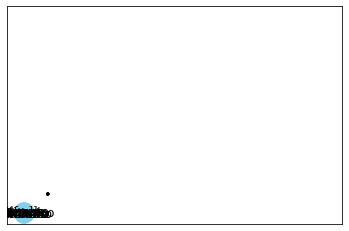

In [23]:

plt.rcParams["figure.figsize"] = (5,5)
pos = nx.circular_layout(G)
nx.draw_networkx(G, with_labels=True, node_color='skyblue', edge_cmap=plt.cm.Blues, pos = pos)
plt.show()


#plt.rcParams["figure.figsize"] = (10,8)

In [24]:
from pyvis.network import Network
net = Network(notebook = True, width="1000px", height="700px", bgcolor='#ffffff', font_color='black')

node_degree = dict(G.degree)

#Setting up node size attribute
nx.set_node_attributes(G, node_degree, 'size')

net.from_nx(G)
net.show("Filumena.html")

Filumena.html


In [25]:
# Degree centrality
degree_dict = nx.degree_centrality(G)
degree_dict
#number of times the circles touches the edges is the degree
#in the dictionary we see that gandalf should be the largest node in our graph


{'Domenico': 0.7777777777777777,
 'Lucia': 0.7777777777777777,
 'Alfredo': 0.5555555555555556,
 'Rosalia': 0.7777777777777777,
 'Filomena': 0.8888888888888888,
 'Diana': 0.6666666666666666,
 'Riccardo': 0.4444444444444444,
 'Umberto': 0.7777777777777777,
 'Michele': 0.4444444444444444,
 'Avvocato': 0.5555555555555556}

<Axes: >

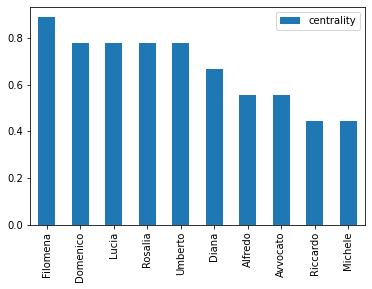

In [26]:
degree_df = pd.DataFrame.from_dict(degree_dict, orient='index', columns=['centrality'])
# Plot top 10 nodes
degree_df.sort_values('centrality', ascending=False).plot(kind="bar")

In [27]:
import pandas as pd
import networkx as nx

# Assuming you have already created the graph G

# Calculate degree centrality
degree_dict = nx.degree_centrality(G)

# Create a DataFrame from the degree centrality dictionary
degree_df = pd.DataFrame.from_dict(degree_dict, orient='index', columns=['Centrality'])

# Sort the DataFrame by degree centrality in descending order
degree_df = degree_df.sort_values('Centrality', ascending=False)

# Reset the index to use the node IDs as a column
degree_df.reset_index(inplace=True)
degree_df = degree_df.rename(columns={'index': 'Node ID'})

# Display the DataFrame
print(degree_df)


    Node ID  Centrality
0  Filomena    0.888889
1  Domenico    0.777778
2     Lucia    0.777778
3   Rosalia    0.777778
4   Umberto    0.777778
5     Diana    0.666667
6   Alfredo    0.555556
7  Avvocato    0.555556
8  Riccardo    0.444444
9   Michele    0.444444


<Axes: >

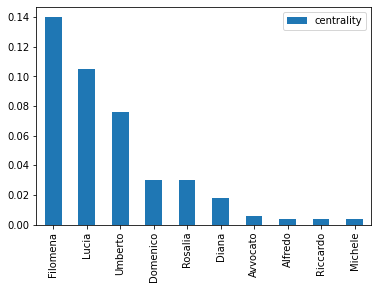

In [28]:
# Betweenness centrality
betweenness_dict = nx.betweenness_centrality(G)
betweenness_df = pd.DataFrame.from_dict(betweenness_dict, orient='index', columns=['centrality'])
# Plot top 10 nodes
betweenness_df.sort_values('centrality', ascending=False).plot(kind="bar")

In [29]:
import pandas as pd
import networkx as nx

# Assuming you have already created the graph G

# Calculate degree centrality
degree_dict = nx.betweenness_centrality(G)

# Create a DataFrame from the degree centrality dictionary
degree_df = pd.DataFrame.from_dict(betweenness_dict, orient='index', columns=['Centrality'])

# Sort the DataFrame by degree centrality in descending order
degree_df = degree_df.sort_values('Centrality', ascending=False)

# Reset the index to use the node IDs as a column
degree_df.reset_index(inplace=True)
degree_df = degree_df.rename(columns={'index': 'Node ID'})

# Display the DataFrame
print(degree_df)


    Node ID  Centrality
0  Filomena    0.139815
1     Lucia    0.105093
2   Umberto    0.075728
3  Domenico    0.030357
4   Rosalia    0.030357
5     Diana    0.017857
6  Avvocato    0.005556
7   Alfredo    0.003968
8  Riccardo    0.003968
9   Michele    0.003968


<Axes: >

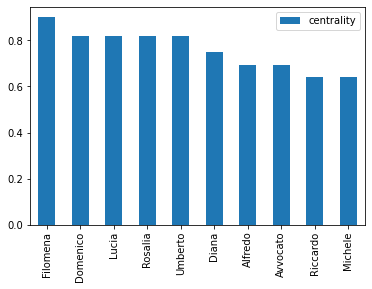

In [30]:
# Closeness centrality
closeness_dict = nx.closeness_centrality(G)
closeness_df = pd.DataFrame.from_dict(closeness_dict, orient='index', columns=['centrality'])
# Plot top 10 nodes
closeness_df.sort_values('centrality', ascending=False).plot(kind="bar")

In [31]:
import pandas as pd
import networkx as nx

# Assuming you have already created the graph G

# Calculate degree centrality
degree_dict = nx.closeness_centrality(G)

# Create a DataFrame from the degree centrality dictionary
degree_df = pd.DataFrame.from_dict(closeness_dict, orient='index', columns=['Centrality'])

# Sort the DataFrame by degree centrality in descending order
degree_df = degree_df.sort_values('Centrality', ascending=False)

# Reset the index to use the node IDs as a column
degree_df.reset_index(inplace=True)
degree_df = degree_df.rename(columns={'index': 'Node ID'})

# Display the DataFrame
print(degree_df)


    Node ID  Centrality
0  Filomena    0.900000
1  Domenico    0.818182
2     Lucia    0.818182
3   Rosalia    0.818182
4   Umberto    0.818182
5     Diana    0.750000
6   Alfredo    0.692308
7  Avvocato    0.692308
8  Riccardo    0.642857
9   Michele    0.642857


In [32]:
import community as community_louvain

In [33]:
communities = community_louvain.best_partition(G)

In [34]:
communities

{'Domenico': 1,
 'Lucia': 1,
 'Alfredo': 1,
 'Rosalia': 1,
 'Filomena': 0,
 'Diana': 1,
 'Riccardo': 0,
 'Umberto': 0,
 'Michele': 0,
 'Avvocato': 1}

In [35]:
nx.set_node_attributes(G, communities, 'group')

In [36]:
com_net = Network(notebook = True, width="1000px", height="700px", bgcolor='#222222', font_color='white')
com_net.from_nx(G)
com_net.show("Filumena_communities.html")

Filumena_communities.html
